In [15]:
from pathlib import Path
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

def find_root():
    p = Path.cwd().resolve()
    for _ in range(12):
        if (p / "data").exists():
            return p
        p = p.parent
    raise FileNotFoundError("No encuentro la carpeta /data. Ejecuta el notebook dentro del repo.")

ROOT = find_root()
SAMPLE = ROOT / "data" / "gold" / "samples" / "bicing_gold_final_plus_sample_1M_strat_holidays.parquet"

print("ROOT:", ROOT)
print("SAMPLE:", SAMPLE)
print("exists:", SAMPLE.exists())

df = pq.read_table(SAMPLE).to_pandas()

df["time_hour"] = pd.to_datetime(df["time_hour"])
df["date"] = pd.to_datetime(df["date"])

print("shape:", df.shape)
print("time range:", df["time_hour"].min(), "->", df["time_hour"].max())
df.head(3)


ROOT: C:\Users\patxi\Documents\GitHub\bicing-barcelona-ml
SAMPLE: C:\Users\patxi\Documents\GitHub\bicing-barcelona-ml\data\gold\samples\bicing_gold_final_plus_sample_1M_strat_holidays.parquet
exists: True
shape: (1000000, 27)
time range: 2019-03-28 18:00:00 -> 2025-12-31 23:00:00


,station_id,time_hour,bikes_available_mean,docks_available_mean,mechanical_mean,ebike_mean,obs_count,hour,dayofweek,month,date,is_weekend,is_holiday,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,pressure_msl,lag_1h_bikes,lag_24h_bikes,roll3h_bikes_mean,is_holiday_new,is_holiday_barcelona,is_holiday_catalunya,is_holiday_spain,holiday_scope,holiday_name
0,504,2020-09-09 20:00:00,2.750000,23.250000,1.250000,1.500000,12,20,2,9,2020-09-09,0,0,20.5,86.0,0.2,7.0,1020.4,0.00,0.153846,1.000000,0,0,0,0,NaN,NaN
1,123,2024-04-14 04:00:00,2.916667,16.083333,0.000000,2.916667,12,4,6,4,2024-04-14,1,0,12.4,61.0,0.0,5.8,1024.9,2.75,0.416667,3.138889,0,0,0,0,NaN,NaN
2,394,2024-11-02 20:00:00,18.250000,5.750000,4.666667,13.583333,12,20,5,11,2024-11-02,1,0,17.5,87.0,0.0,17.4,1022.6,20.75,22.166667,20.305556,0,0,0,0,NaN,NaN


In [16]:
dup_keys = df.duplicated(["station_id", "time_hour"]).sum()
print("dup_keys(sample) =", dup_keys)

holiday_cols = [c for c in df.columns if "holiday" in c.lower() or "festiv" in c.lower()]
print("holiday cols:", holiday_cols)

print("\nCounts holiday flags:")
for c in ["is_holiday_barcelona","is_holiday_catalunya","is_holiday_spain","is_holiday_new","is_holiday"]:
    if c in df.columns:
        print(c, "->", df[c].value_counts(dropna=False).head(5).to_dict())


dup_keys(sample) = 0
holiday cols: ['is_holiday', 'is_holiday_new', 'is_holiday_barcelona', 'is_holiday_catalunya', 'is_holiday_spain', 'holiday_scope', 'holiday_name']

Counts holiday flags:
is_holiday_barcelona -> {0: 959568, 1: 40432}
is_holiday_catalunya -> {0: 906788, 1: 93212}
is_holiday_spain -> {0: 833644, 1: 166356}
is_holiday_new -> {0: 700000, 1: 300000}
is_holiday -> {0: 1000000}


In [17]:
for c in ["is_holiday_barcelona","is_holiday_catalunya","is_holiday_spain"]:
    if c not in df.columns:
        raise KeyError(f"Falta columna: {c}")

df["holiday_any"] = (
    df["is_holiday_barcelona"].fillna(0).astype(int)
    | df["is_holiday_catalunya"].fillna(0).astype(int)
    | df["is_holiday_spain"].fillna(0).astype(int)
).astype(int)

# Scope final (prioridad: barcelona > catalunya > spain)
def scope_row(r):
    if r["is_holiday_barcelona"] == 1:
        return "barcelona"
    if r["is_holiday_catalunya"] == 1:
        return "catalunya"
    if r["is_holiday_spain"] == 1:
        return "spain"
    return "none"

df["holiday_scope_final"] = df.apply(scope_row, axis=1)

print(df["holiday_any"].value_counts())
print(df["holiday_scope_final"].value_counts())


holiday_any
0    700000
1    300000
Name: count, dtype: int64
holiday_scope_final
none         700000
spain        166356
catalunya     93212
barcelona     40432
Name: count, dtype: int64


In [18]:
nulls = df.isna().sum().sort_values(ascending=False).head(15)
nulls.to_frame("null_count")


,null_count
holiday_scope,700000
holiday_name,700000
lag_24h_bikes,75197
lag_1h_bikes,136
station_id,0
ebike_mean,0
obs_count,0
hour,0
dayofweek,0
time_hour,0


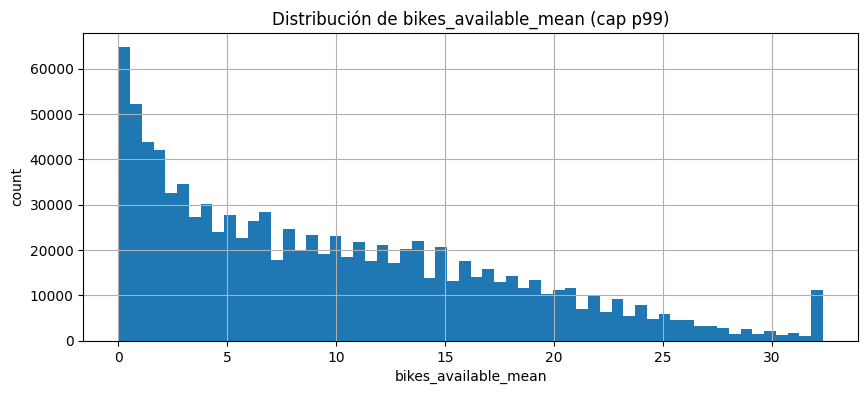

In [19]:
plt.figure(figsize=(10,4))
df["bikes_available_mean"].clip(0, df["bikes_available_mean"].quantile(0.99)).hist(bins=60)
plt.title("Distribución de bikes_available_mean (cap p99)")
plt.xlabel("bikes_available_mean")
plt.ylabel("count")
plt.show()


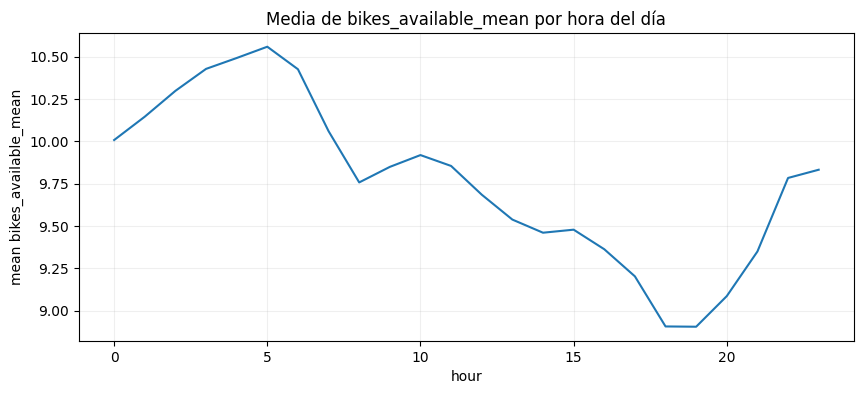

In [20]:
g = df.groupby("hour")["bikes_available_mean"].mean()

plt.figure(figsize=(10,4))
g.plot()
plt.title("Media de bikes_available_mean por hora del día")
plt.xlabel("hour")
plt.ylabel("mean bikes_available_mean")
plt.grid(True, alpha=0.2)
plt.show()


C:\Users\patxi\AppData\Local\Temp\ipykernel_14528\42189125.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([d0, d1], labels=["No festivo", "Festivo"], showfliers=False)


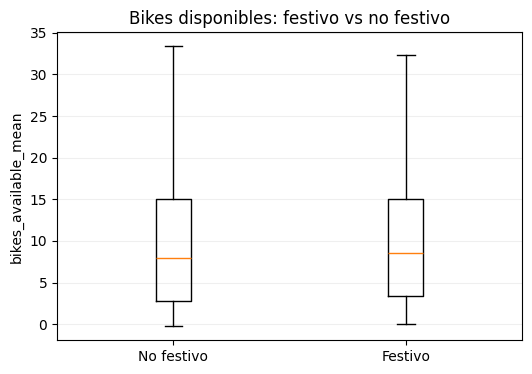

In [21]:
d0 = df[df["holiday_any"] == 0]["bikes_available_mean"].dropna()
d1 = df[df["holiday_any"] == 1]["bikes_available_mean"].dropna()

plt.figure(figsize=(6,4))
plt.boxplot([d0, d1], labels=["No festivo", "Festivo"], showfliers=False)
plt.title("Bikes disponibles: festivo vs no festivo")
plt.ylabel("bikes_available_mean")
plt.grid(True, axis="y", alpha=0.2)
plt.show()


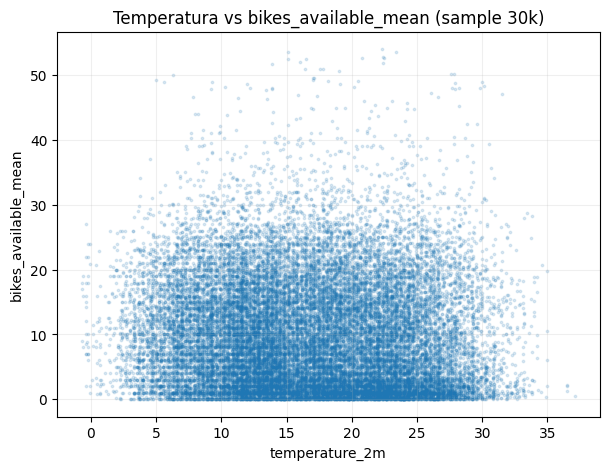

In [22]:
tmp = df.sample(30000, random_state=7)  # para que no explote
plt.figure(figsize=(7,5))
plt.scatter(tmp["temperature_2m"], tmp["bikes_available_mean"], s=3, alpha=0.15)
plt.title("Temperatura vs bikes_available_mean (sample 30k)")
plt.xlabel("temperature_2m")
plt.ylabel("bikes_available_mean")
plt.grid(True, alpha=0.2)
plt.show()


In [23]:
num_cols = df.select_dtypes(include="number").columns
corr = df[num_cols].corr(numeric_only=True)["bikes_available_mean"].sort_values(ascending=False)
corr.head(15)


bikes_available_mean    1.000000
roll3h_bikes_mean       0.958127
lag_1h_bikes            0.935780
mechanical_mean         0.875124
lag_24h_bikes           0.611987
ebike_mean              0.388633
relative_humidity_2m    0.028828
is_holiday_spain        0.016247
is_holiday_new          0.013736
holiday_any             0.013736
dayofweek               0.009391
is_holiday_catalunya    0.007831
is_weekend              0.006012
precipitation           0.004363
wind_speed_10m          0.000805
Name: bikes_available_mean, dtype: float64